# Importing, setup and helper visualisation functions

Here we just set up some of the functions we'll need to easily see environments once we've generated them.

In [1]:
from minihack.tiles import GlyphMapper
gm = GlyphMapper()
import math

import IPython.display
import PIL.Image
from minihack import MiniHackNavigation

def display(x, resize=None, relative=True, return_image=False):
    image = PIL.Image.fromarray(x)
    if resize is not None:
        x_resize, y_resize = resize
        if relative:
            image = image.resize((int(image.width * x_resize), int(image.height * y_resize)))
        else:
            image = image.resize((x_resize, y_resize))
    if return_image:
        return image
    IPython.display.display(image)
    
def save(x, name):
    t = PIL.Image.fromarray(x)
    t.save(f"/Users/robert/workspace/{name}.png")
    
observation_keys = (
     "pixel_crop",
     "pixel",
)

def get_obs(env):
    env.reset()
    for c in "#wizintrinsic\rt\r\r":
        obs,sds = env.env.step(ord(c))
    obs,_,_,_ =env.step(0)
    return obs

def render_des_file(des_file, n_images=1):
    class COR(MiniHackNavigation):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, des_file=des_file, **kwargs)
        
    env = COR(savedir=None,archivefile=None,observation_keys=observation_keys)
    if n_images == 1:
        obs = get_obs(env)
        display(obs["pixel"], resize=(0.5, 0.5), relative=True)
    else:
        images = []
        for i in range(n_images):
            obs = get_obs(env)
            images.append(display(obs["pixel"], resize=(0.5,0.5), relative=True, return_image=True))
        width = images[0].width
        height = images[0].height
        result = PIL.Image.new('RGB', ((width * 3) + 10, ((height + 5) * math.ceil(n_images / 3)) - 5), color=(200,200,200))
        for j in range(math.ceil(n_images / 3)):
            for i in range(3):
                try:
                    result.paste(images[(j * 3) + i], ((width + 5) * i, (height + 5) * j))
                except IndexError:
                    IPython.display.display(result)
                    return
        IPython.display.display(result)

# Des-file Tutorial

This tutorial assumes a small amount of knowledge of NetHack, and that you've at-least skimmed the [des-file-format](https://nethackwiki.com/wiki/Des-file_format) wiki page.

## What is a des-file?

A _des-file_ is a file which describes a level in the game of NetHack. In MiniHack, we use des-files to easily define new environments. The des-files are specified in a human-readable domain-specific language, which has some powerful probabilistic features which enable easy specification of interesting distributions of levels in only a few lines. While there are many features of these files and the DSL used to specify them, in this tutorial we will highlight the most relevant ones, which are most useful for designing environments for RL research.

## The Two Types of des-files: MAZE and ROOM

There are two types of des-file, which have different properties in terms of how they define the layout of the level:
* The ROOM-type des-file works by specifying a collection of ROOMs, possibly with SUBROOMs. Any of these rooms and subrooms can have their contents specified, as well as their approximate location and exact size. These rooms are then randomly places (loosely obeying the approximate location) on the map. Generally, the RANDOM_CORRIDORS command is then used to create random corridors enabling access to all the rooms on the map.
* The MAZE-type des-file offers more control over defining the layout of the level. The layout can be "drawn" with ascii characters, and then contents can be specified to occupy certain locations on the level. The layout specified could only occupy part of the map, with the other parts being randomly generated.

### MAZE-type levels

Let's look at a simple MAZE-type des-file:

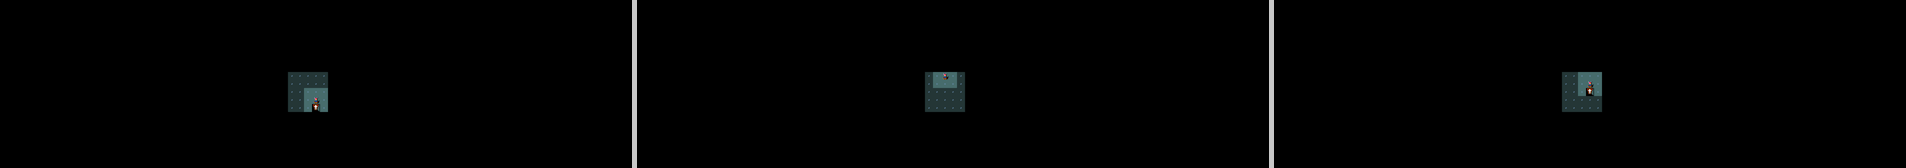

In [2]:
des_file = """
MAZE: "mylevel", ' '
FLAGS:premapped
GEOMETRY:center,center
MAP
.....
.....
.....
.....
.....
ENDMAP
"""
render_des_file(des_file, n_images=3)

Here we can already see some basic structure of the des-file. The first line specifies the type (either MAZE: for maze-type or LEVEL: for room-type). The second line specifies a possible list of flags to apply to the level. Here we're using `premapped` so we can easily visualise the entire level. `GEOMETRY` determines where the following `MAP` definition will be on the whole screen, and `MAP` defines the map itself. `.` is a floor tile, and everything not specified becomes impassable rock.

Let's experiment with GEOMETRY to see what it does:

Levels with geometry: GEOMETRY:left,top


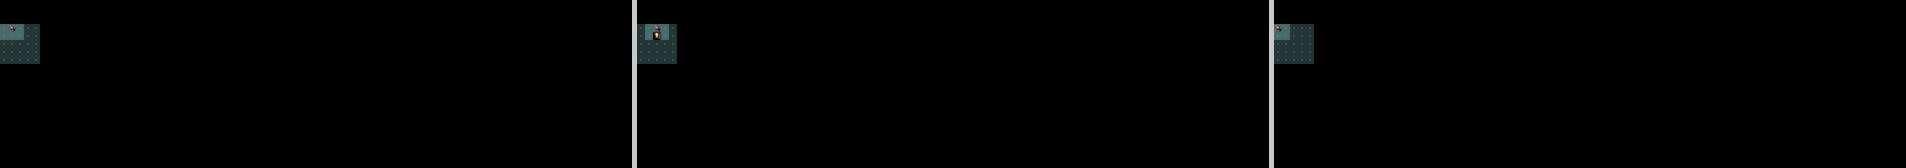

Levels with geometry: GEOMETRY:center,center


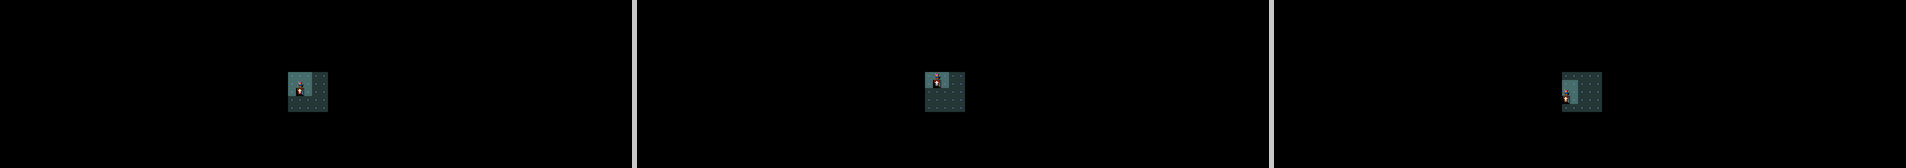

Levels with geometry: GEOMETRY:right,bottom


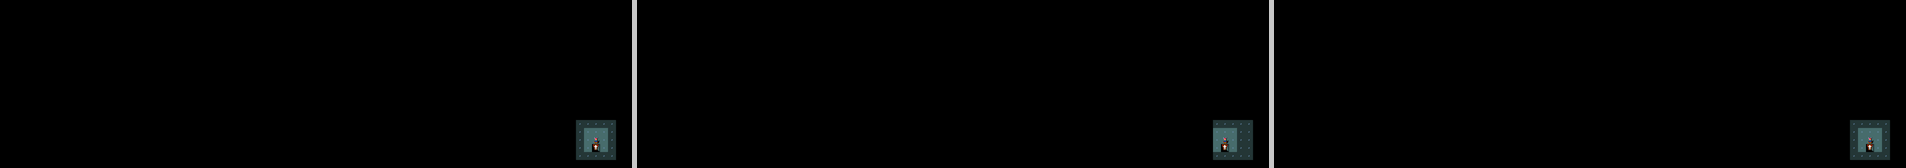

In [3]:
des_file = """
MAZE: "mylevel", ' '
FLAGS:premapped
GEOMETRY:{},{}
MAP
.....
.....
.....
.....
.....
ENDMAP
"""
for geom_x, geom_y in [("left", "top"), ("center", "center"), ("right", "bottom")]:
    print("Levels with geometry: GEOMETRY:{},{}".format(geom_x, geom_y))
    render_des_file(des_file.format(geom_x, geom_y), n_images=3)

Lets try making the map a bit more interesting. Feel free to play around and make an interesting design. Some constraints: all lines must be the same length (you can use spaces to fill up the ends of lines if you want), and the whole maze must be within 79 x 21 size

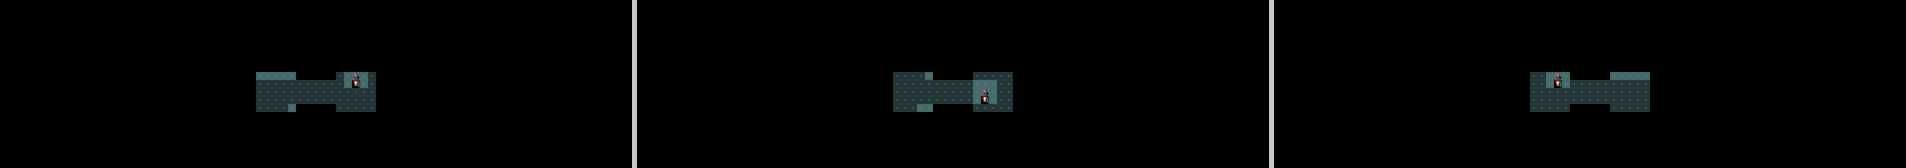

In [4]:
des_file = """
MAZE: "mylevel", ' '
FLAGS:premapped
GEOMETRY:center,center
MAP
.....     .....
...............
...............
...............
.....     .....
ENDMAP
"""
render_des_file(des_file, n_images=3)

So far we've just changed the shape of the map, but what about making it out of something other than floor and walls? You can use any of the map characters defined in the des-file format; see [here for the full list](https://nethackwiki.com/wiki/Des-file_format#Map_characters). For example, we could add a sink, some trees, a door, and some walls

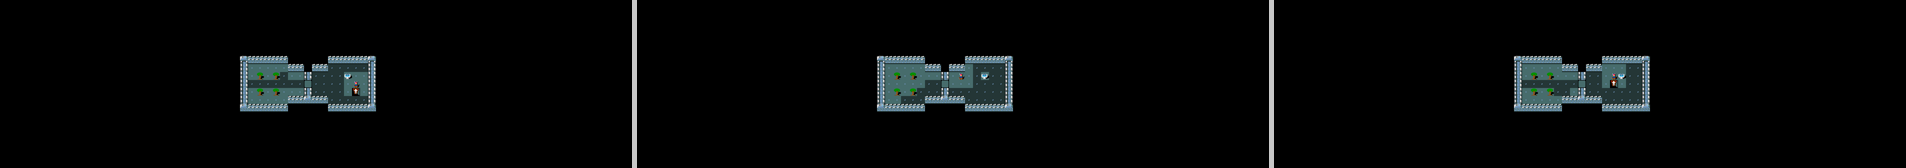

In [5]:
des_file = """
MAZE: "mylevel", ' '
FLAGS:premapped
GEOMETRY:center,center
MAP
|-----     ------
|.....-- --.....|
|.T.T...-....K..|
|.......+.......|
|.T.T...-.......|
|.....-----.....|
|-----     ------
ENDMAP
"""
render_des_file(des_file, n_images=3)

A good thing about MAZE levels is you can specify the starting point of the agent explicitly, using the `BRANCH` command. This command takes in two regions as input, and spawns the agent somewhere in the first region, as long as it's not in the second region. If you want the agent to spawn in a single spot, you can just pass the same coordinates twice. In the previous maps the agent has been spawning in a random location - lets try and spawn them in the middle of the four trees.

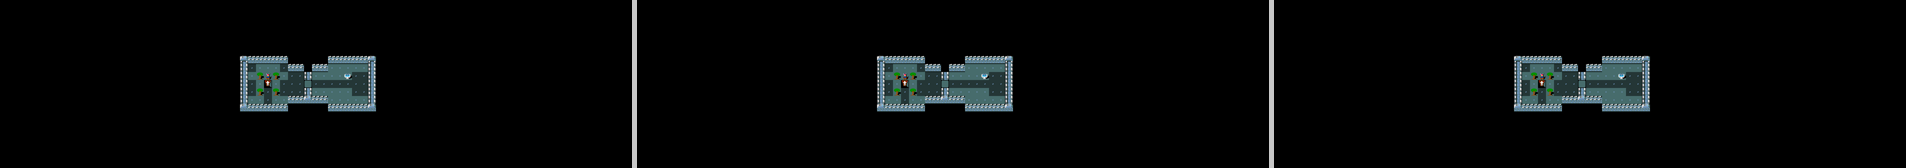

In [6]:
des_file = """
MAZE: "mylevel", ' '
FLAGS:premapped
GEOMETRY:center,center
MAP
|-----     ------
|.....-- --.....|
|.T.T...-....K..|
|.......+.......|
|.T.T...-.......|
|.....-----.....|
|-----     ------
ENDMAP
BRANCH: (3,3,3,3),(4,4,4,4)
"""
render_des_file(des_file, n_images=3)

### ROOM-type levels

Let's look at a simple ROOM-type des-file:

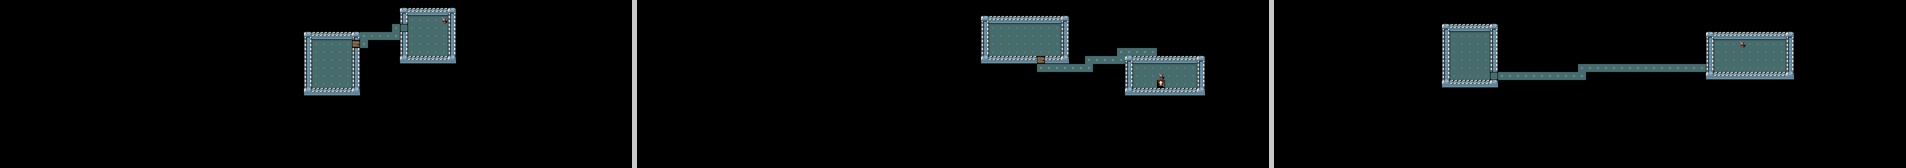

In [7]:
des_file = """
LEVEL: "mylevel"
FLAGS: premapped

ROOM: "ordinary" , lit, random, random, random {
}
ROOM: "ordinary" , lit, random, random, random {
}

RANDOM_CORRIDORS
"""
render_des_file(des_file, n_images=3)

This has a similar structure in the beginning of the file to the MAZE-type levels, using flags to specify some options. After that, several `ROOM`s are defined. The arguments to the `ROOM` command are:

* type, which specifies the type of room (generally we'll just want ordinary)
* lit or unlit - this controls how far the agent can see in the room
* position, a tuple with values between 1 and 5 which roughly specifies the room location
* align, a tuple of xalign and yalign. This specifies the alignment of the room within the position defined above
    * xalign is one of left, half-left, center, half-right, right or random
    * yalign is one of top, center, bottom or random.
* size, a tuple of (height, width).

Any of these can be left as `random`, which means they're randomly chosen. 

Let's experiments with each of these arguments in turn, to get an idea of what they do to just one room:

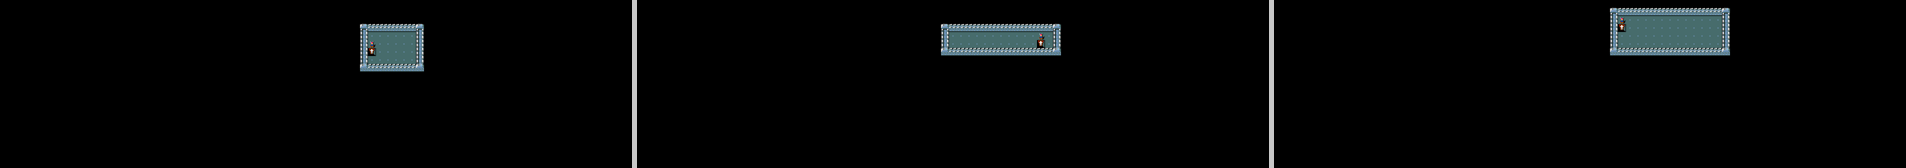

In [8]:
des_file = """
LEVEL: "mylevel"
FLAGS: premapped
ROOM: "ordinary" , lit, random, random, random {
}
RANDOM_CORRIDORS
"""
render_des_file(des_file, n_images=3)

Room placed with position:  1 , 1


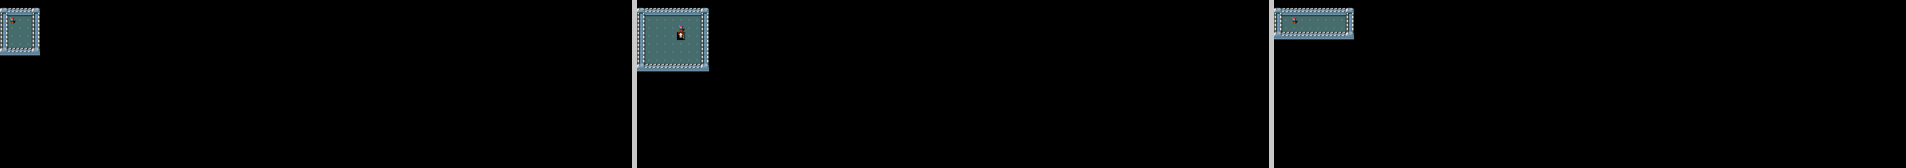

Room placed with position:  1 , 5


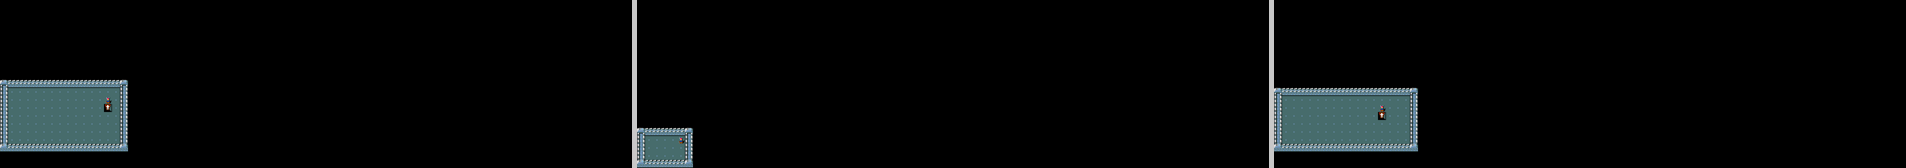

Room placed with position:  5 , 1


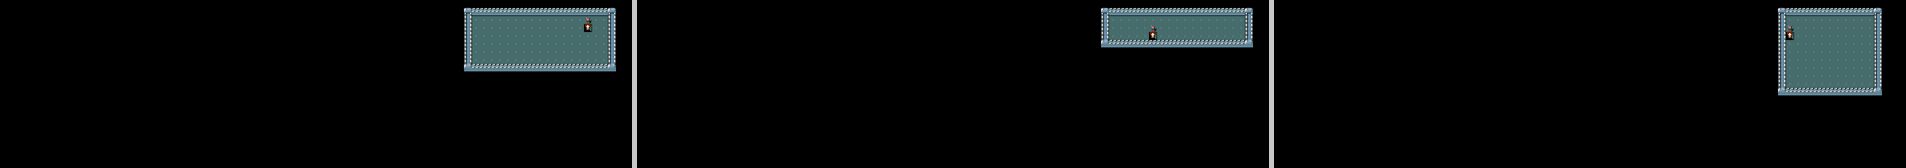

Room placed with position:  5 , 5


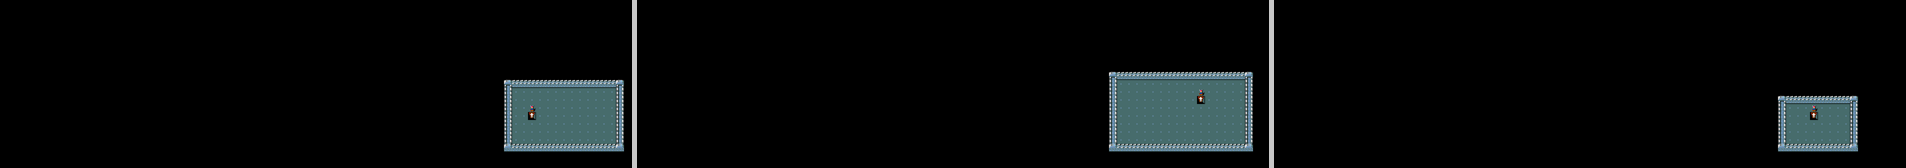

In [9]:
des_file = """
LEVEL: "mylevel"
FLAGS: premapped

ROOM: "ordinary" , lit, (XX,YY), random, random {
}

RANDOM_CORRIDORS
"""
for x,y in [(1,1), (1,5), (5,1), (5,5)]:
    print("Room placed with position: ", x, ",", y)
    render_des_file(des_file.replace("XX", str(x)).replace("YY", str(y)), n_images=3)

Room placed with align:  left , top


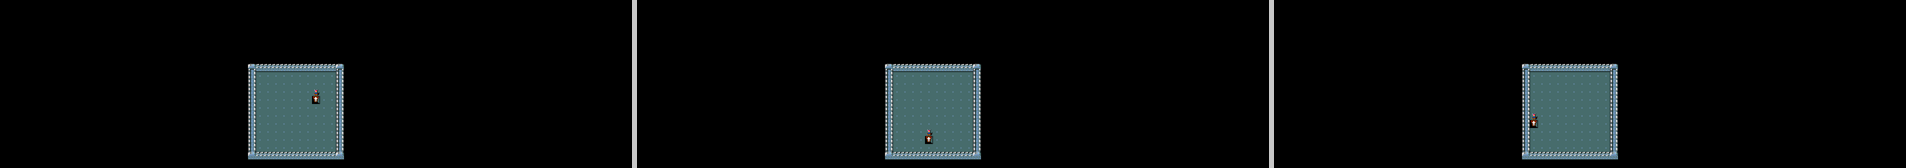

Room placed with align:  right , top


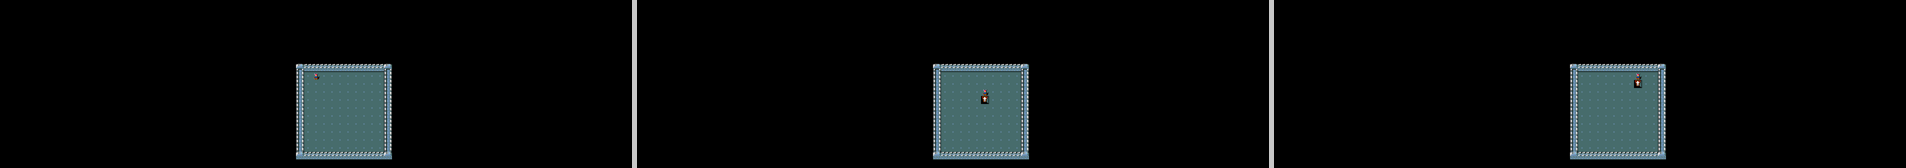

Room placed with align:  right , bottom


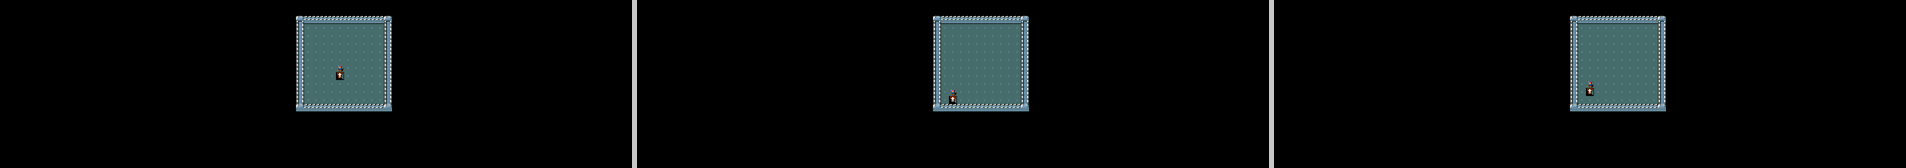

Room placed with align:  center , center


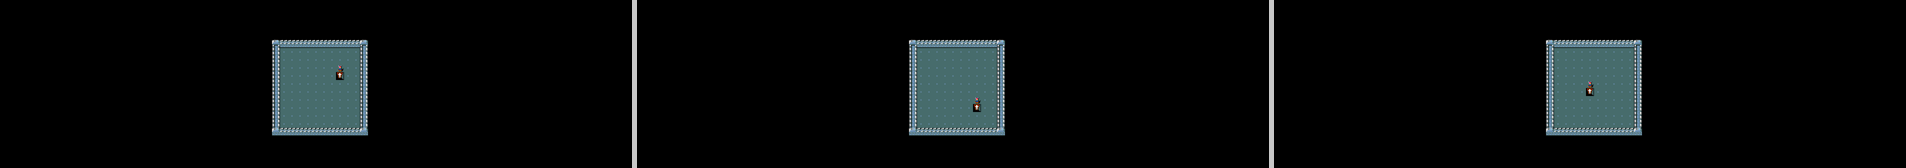

In [10]:
des_file = """
LEVEL: "mylevel"
FLAGS: premapped

ROOM: "ordinary" , lit, (3,3), (xalign,yalign), (10,10) {
}

RANDOM_CORRIDORS
"""
for xalign,yalign in [("left", "top"), ("right", "top"), ("right", "bottom"), ("center", "center")]:
    print("Room placed with align: ", xalign, ",", yalign)
    render_des_file(des_file.replace("xalign", xalign).replace("yalign", yalign), n_images=3)

When defining a ROOM-type level, we can also place subrooms within rooms. These subrooms are initialised in a similar way to ROOMs

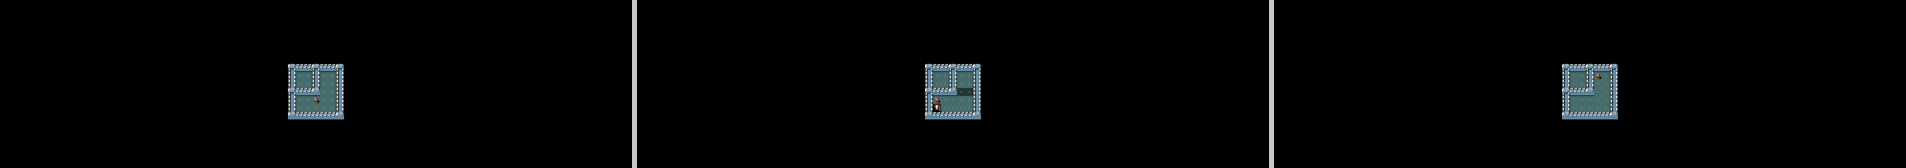

In [11]:
des_file = """
LEVEL: "mylevel"
FLAGS: premapped

ROOM: "ordinary" , lit, (3,3), (center,center), (5,5) {
    SUBROOM: "ordinary", lit, (0,0), (2,2) {
    }
}

RANDOM_CORRIDORS
"""
render_des_file(des_file, n_images=3)

Finally, we should probably explain the `RANDOM_CORRIDORS` command. This command creates random corridors between all the rooms. Look what happens if we don't include it (we won't be able to get between the rooms).

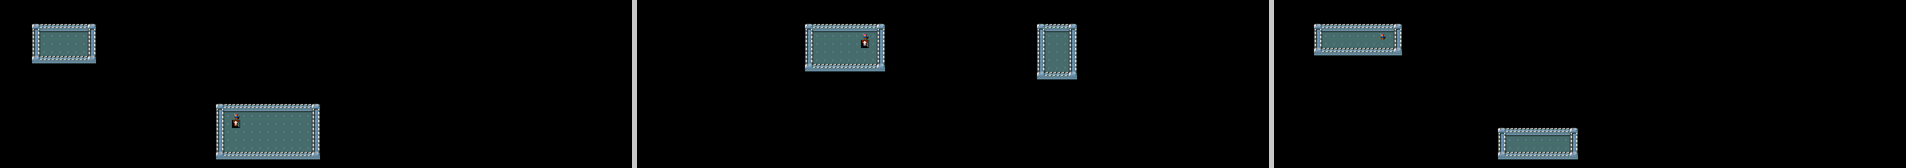

In [12]:
des_file = """
LEVEL: "mylevel"
FLAGS: premapped

ROOM: "ordinary" , lit, random, random, random {
}
ROOM: "ordinary" , lit, random, random, random {
}
"""
render_des_file(des_file, n_images=3)

## Adding complexity: Monsters, Objects & Traps

While making nice mazes or rooms is all well and good, we want our agents to tackle more interesting challenges. This is where we start to draw on the richness of the game of NetHack; specifically, we'll see how to add monsters, objects and traps to the levels we've defined. These commands work the same for both ROOM and MAZE type levels, with one nuance when defining the location of these entities: in MAZE-type levels, the coordinates given are relative to the most recent MAP definintion; for ROOM-type levels, they're relative to the ROOM containing the entity being added.

Let's see how to add a monster to our 2-room environment from earlier (we've added a lit region covering the whole map, so that we can see what's happening everywhere):

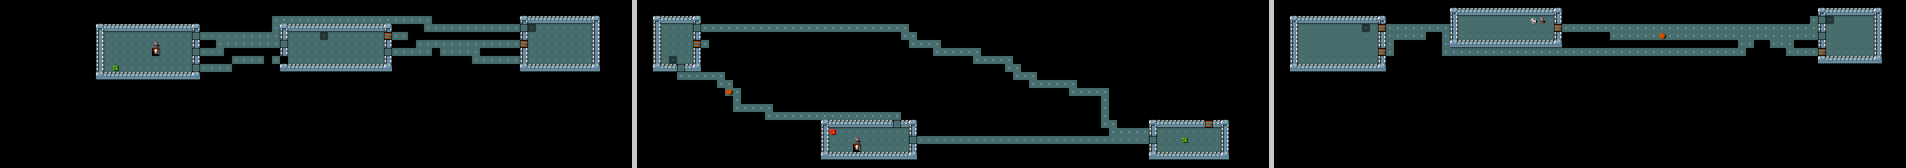

In [13]:
des_file = """
LEVEL: "mylevel"
FLAGS: premapped
REGION: (0,0,20,80), lit, "ordinary"

ROOM: "ordinary" , lit, random, random, random {
    MONSTER: random, random
}
ROOM: "ordinary" , lit, random, random, random {
    MONSTER: ('F', "lichen"), random
}
ROOM: "ordinary" , lit, random, random, random {
    MONSTER: ('F', "red mold"), (0,0)
}

RANDOM_CORRIDORS
"""
render_des_file(des_file, n_images=3)

We can specify the monster type with a tuple of class and name (e.g. `('F', "lichen")`), or leave it random. Similarly with the location, we can leave it random or specify it, as we did in the last room.

Adding traps is very similar to adding monsters, apart from we just need the trap name rather than the tuple of name and class:

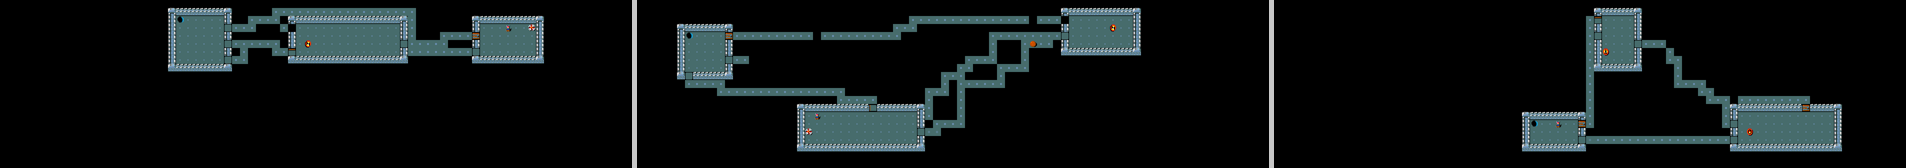

In [14]:
des_file = """
LEVEL: "mylevel"
FLAGS: premapped
REGION: (0,0,20,80), lit, "ordinary"

ROOM: "ordinary" , lit, random, random, random {
    TRAP: random, random
}
ROOM: "ordinary" , lit, random, random, random {
    TRAP:"fire", random
}
ROOM: "ordinary" , lit, random, random, random {
    TRAP:"hole",(0,0)
}

RANDOM_CORRIDORS
"""
render_des_file(des_file, n_images=3)

As well as monsters and traps, there are many objects in the game of NetHack that we can add to our level. We can specify the type, the location, and for certain objects extra arguments can be passed specific to that object (e.g. the status or the monster egg).

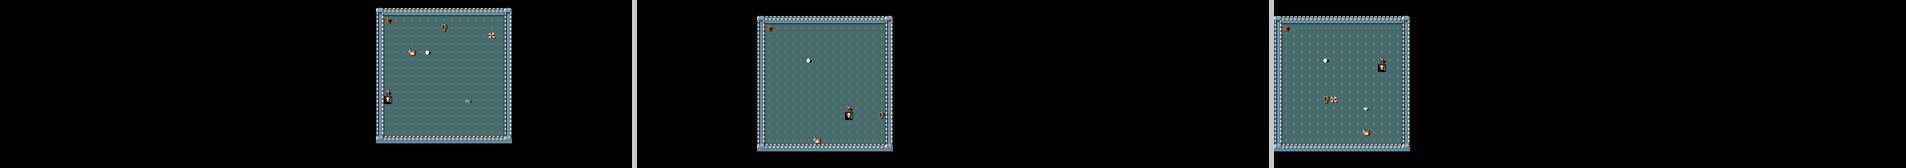

In [15]:
des_file = """
LEVEL: "mylevel"
FLAGS: premapped
REGION: (0,0,20,80), lit, "ordinary"

ROOM: "ordinary", lit, random, (center,center), (15,15) {
    OBJECT:('%', "food ration"), random
    OBJECT:'*', (10,10)
    OBJECT :('"', "amulet of life saving"), random
    OBJECT:('%', "corpse"), random
    OBJECT:('`', "statue"), (0,0), montype:"forest centaur", 1
    OBJECT:('(', "crystal ball"), (17,08), blessed, 5,name:"The Orb of Fate"
    OBJECT:('%',"egg"), (05,04), montype:"yellow dragon"
}

RANDOM_CORRIDORS
"""
render_des_file(des_file, n_images=3)

As well as objects placed with `OBJECT`, there are several terrain features it's worth knowing about: `SINK`, `FOUNTAIN`, `ALTAR`, and `STAIR`. Stairs down are normally the objective for the level, as they lead deeper into the dungeon (unless you specify your own).

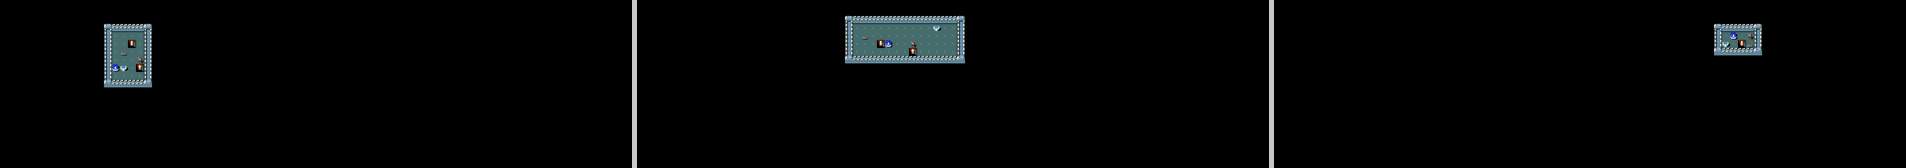

In [16]:
des_file = """
LEVEL: "mylevel"
FLAGS: premapped
REGION: (0,0,20,80), lit, "ordinary"

ROOM: "ordinary" , lit, random, random, random {
    SINK: random
    FOUNTAIN: random
    ALTAR: random, random, random
    STAIR: random, down
}

RANDOM_CORRIDORS
"""
render_des_file(des_file, n_images=3)

### Landscaping Terrain: selections and coordinates

So far we've seen how to create rooms and mazes, and add objects, traps and monsters to those rooms. Now we come to another way to add complexity to your environments: terrain. This takes the form of static objects or structures in the environment (such as trees, clouds, water and lava), all of which have different properties. When placing these pieces of terrain, we control their location exactly or leave it entirely to chance (in a similar way as for monsters, objects and traps). There's also a third option, which enables us to specify complex selections (sets of coordinates) and randomly place terrain within these selections.

First, lets look at the basic types of terrain:

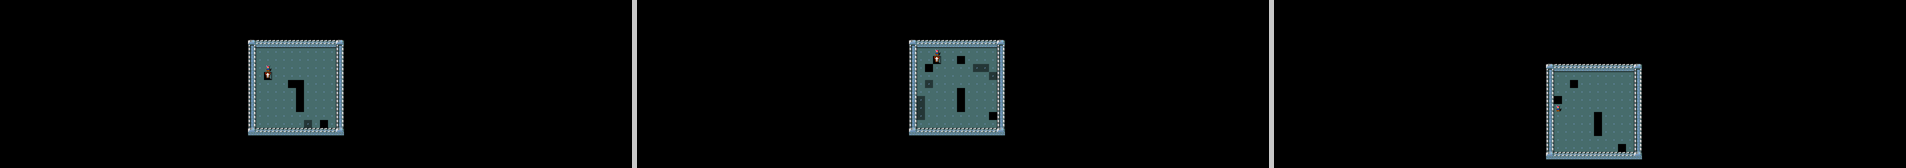

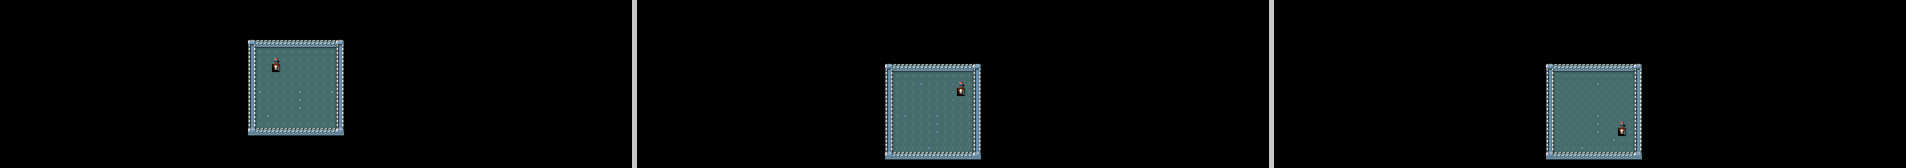

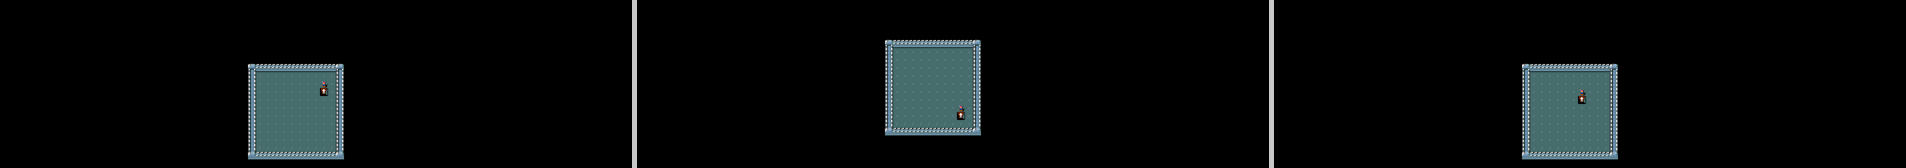

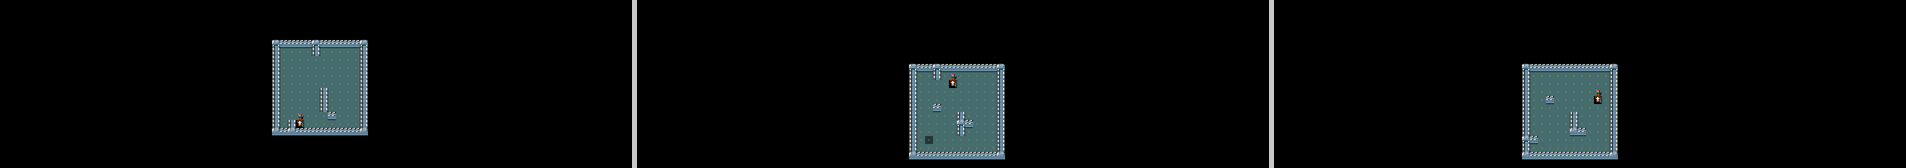

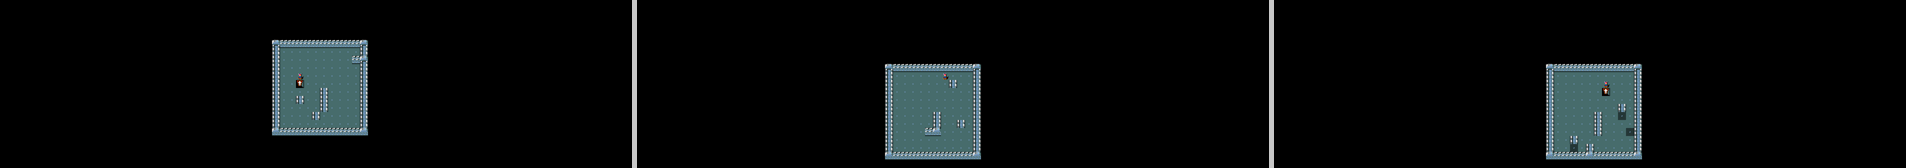

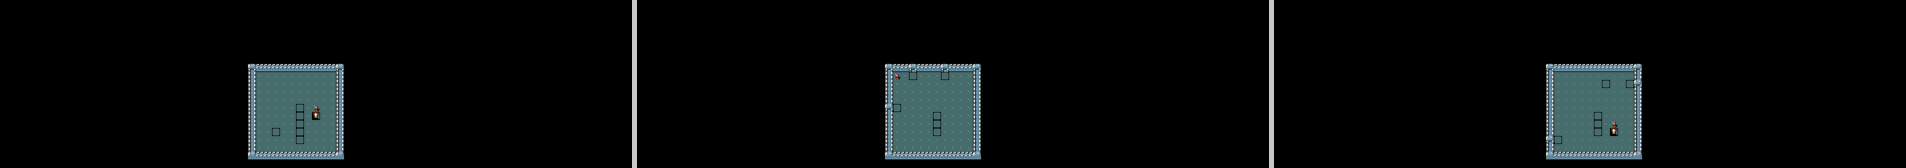

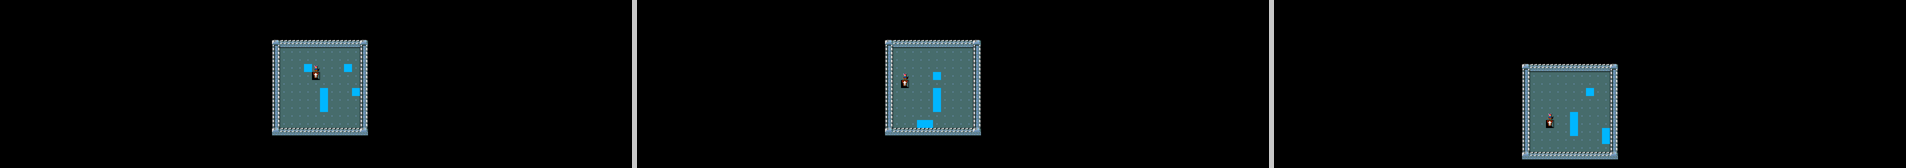

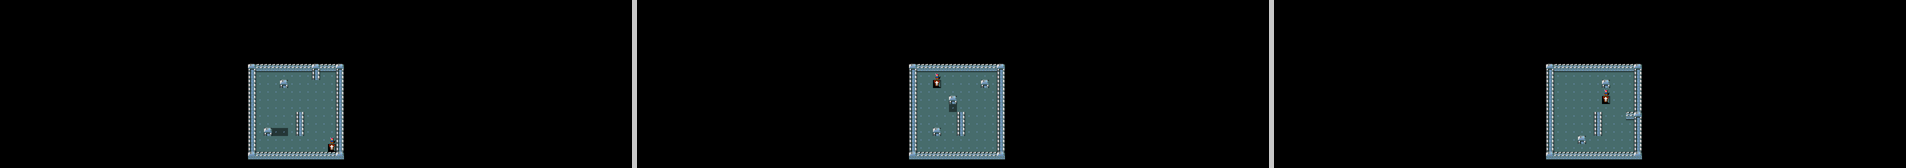

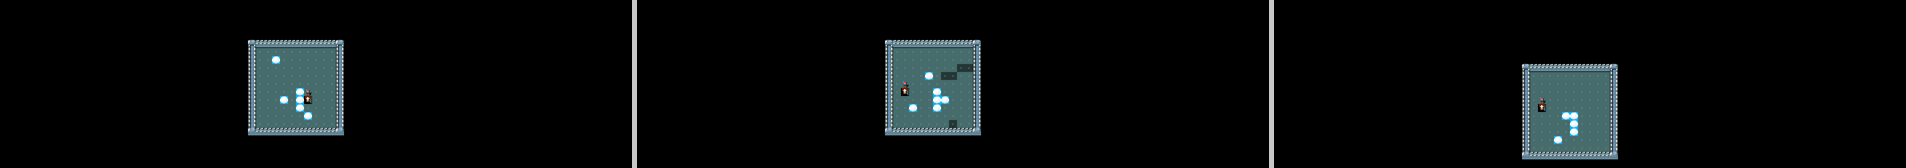

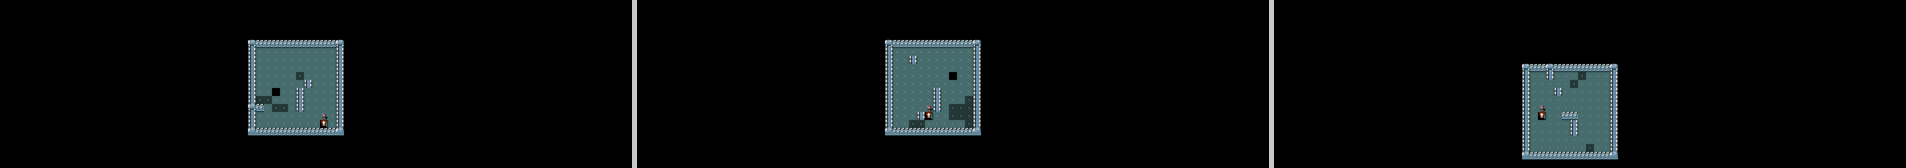

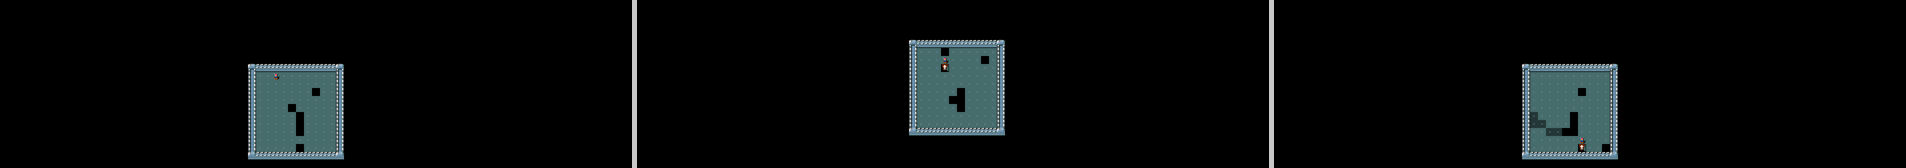

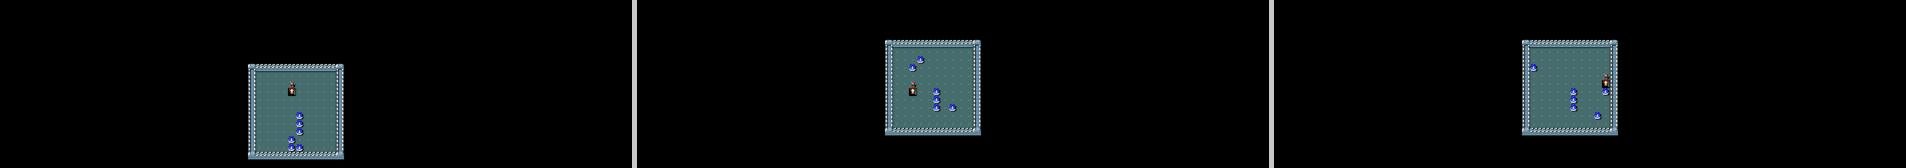

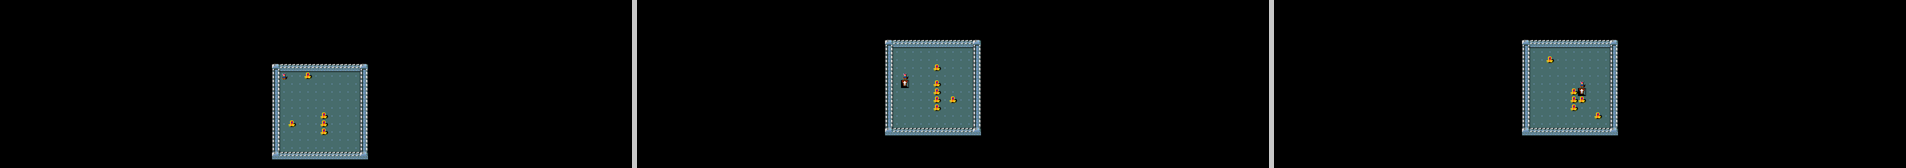

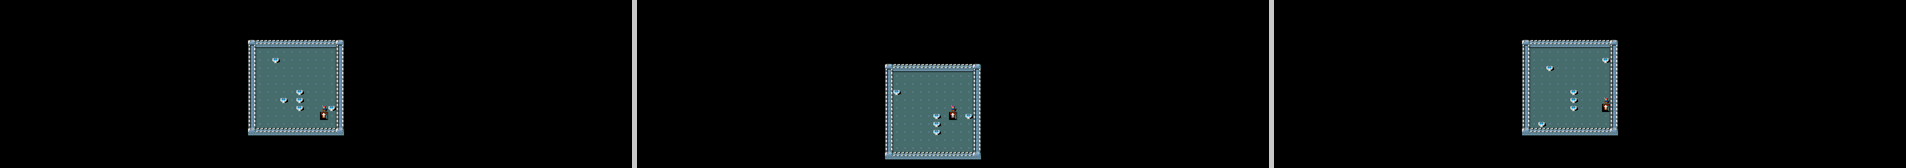

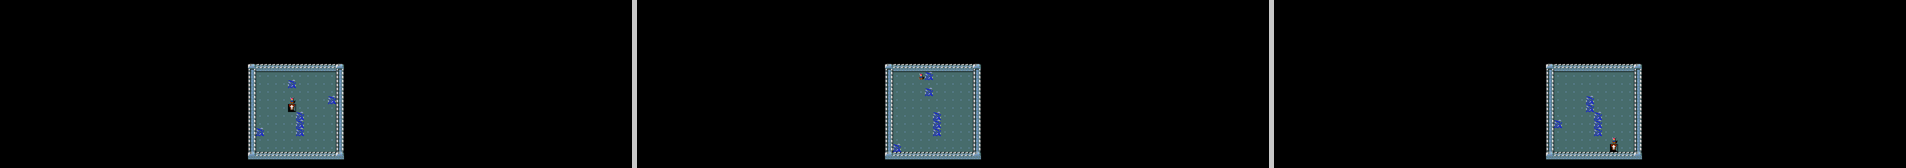

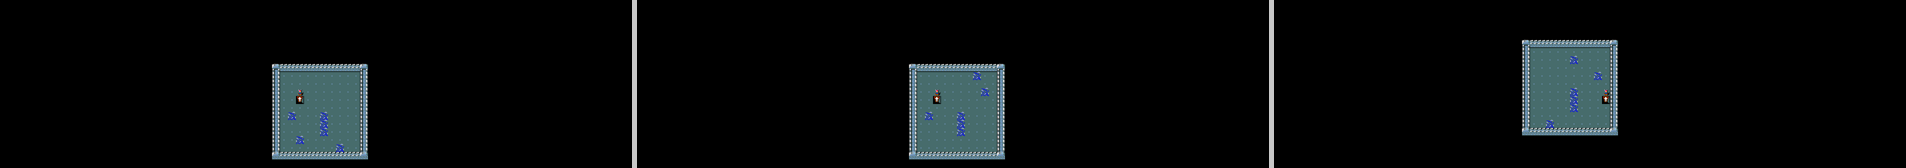

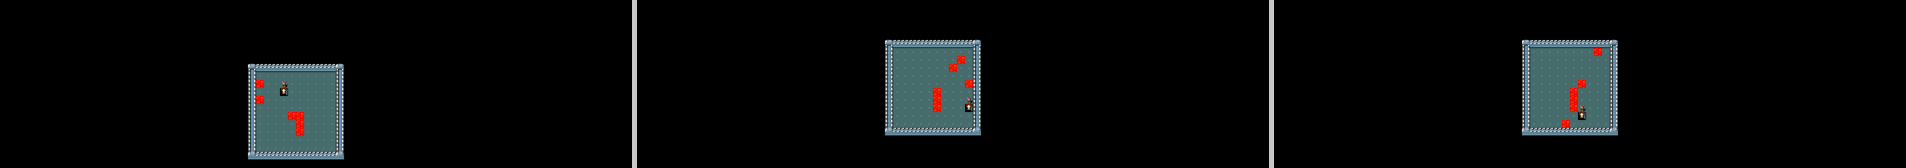

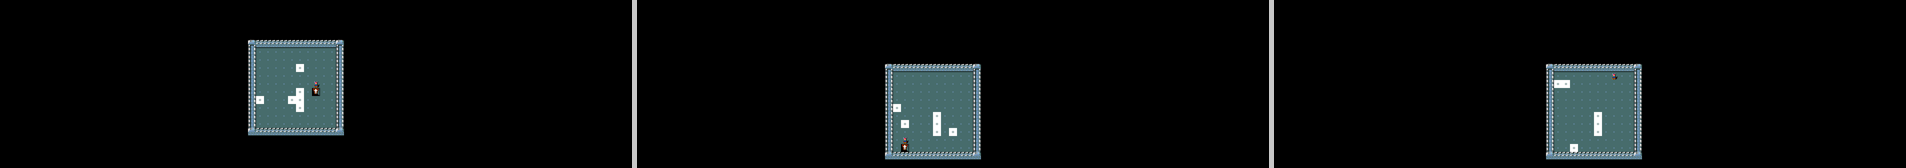

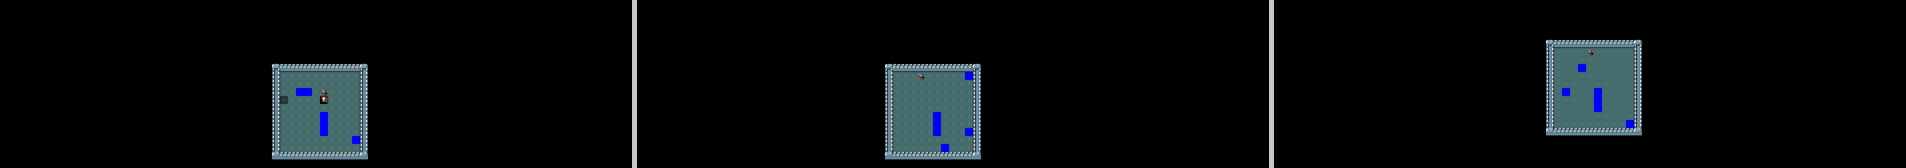

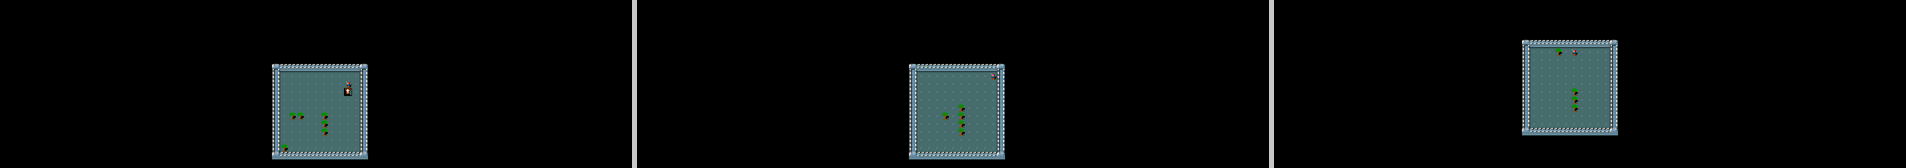

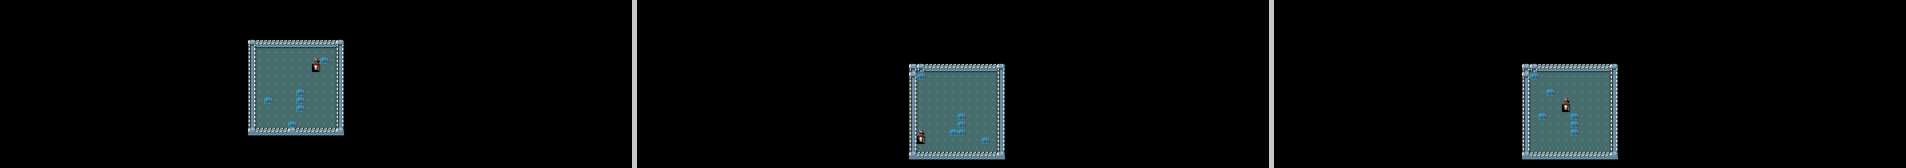

In [17]:
des_file = """
LEVEL: "mylevel"
FLAGS: premapped
REGION: (0,0,20,80), lit, "ordinary"

ROOM: "ordinary" , lit, (3,3), random, (10,10) {
    TERRAIN: (5,5), '%terrain%'
    TERRAIN: (5,6), '%terrain%'
    TERRAIN: (5,7), '%terrain%'
    TERRAIN: random, '%terrain%'
    TERRAIN: random, '%terrain%'
    TERRAIN: random, '%terrain%'
}

RANDOM_CORRIDORS
"""

Terrains = [
    " ",  # solid wall
    "#",  # corridor
    ".",  # room floor (Unlit, unless lit with REGION-command)
    "-",  # horizontal wall
    "|",  # vertical wall
    "+",  # door (State is defined with DOOR -command)
    "A",  # air
    "B",  # crosswall / boundary symbol hack (See REGION)
    "C",  # cloud
    "S",  # secret door
    "H",  # secret corridor
    "{",  # fountain
    "\\", # throne
    "K",  # sink
    "}",  # moat
    "P",  # pool of water
    "L",  # lava pool
    "I",  # ice
    "W",  # water
    "T",  # tree
    "F",  # iron bars
]

for terrain in Terrains:
    render_des_file(des_file.replace("%terrain%", terrain), n_images=3)

Adding terrain in fixed or entirely random places is great, but what if we want to control where the terrain is placed? For these we can use _selections_. These are collections of coordinates that can be combined, and then randomly selected from to place terrain. We can also use the selections without randomness to put terrain in an entire location. There are several ways of creating these selections. `rect` takes a region (specified by `(x_left, y_left, x_right, y_right)` specifying the top left and bottom right corners) and returns selection of coordinates on the edge of the rectangle. `fillrect` returns the entire filled rectangle coordinates

Using fillrect


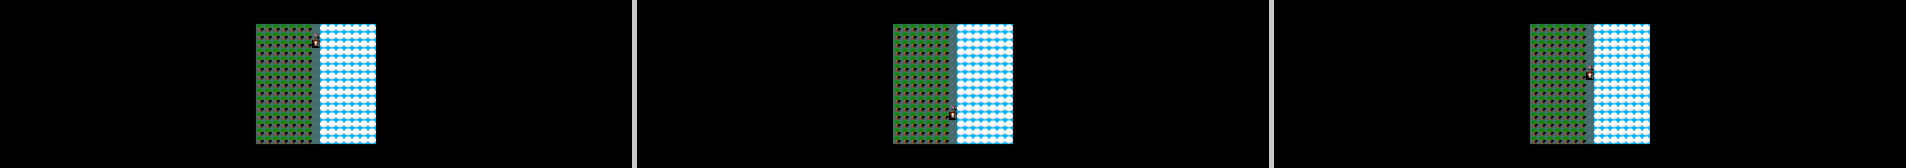

Using rect


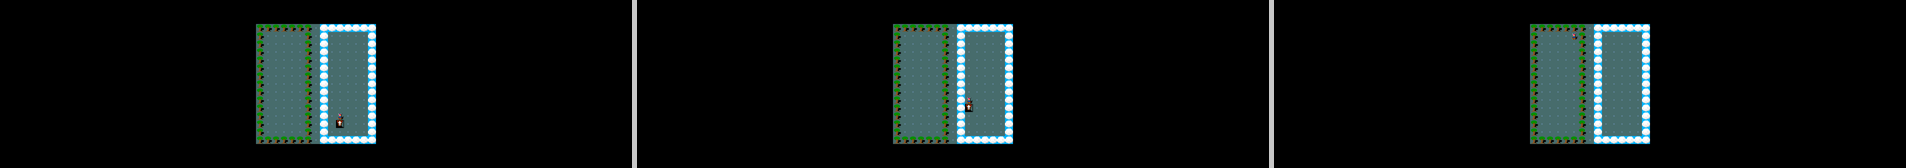

In [18]:
des_file = """
MAZE: "mylevel", ' '
FLAGS:premapped
GEOMETRY:center,center
MAP
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
ENDMAP
REGION: (0,0,20,20), lit, "ordinary"

$left = selection: %rect% (0,0,6,14)
$right = selection: %rect% (8,0,14,14)

TERRAIN: $left, 'T'
TERRAIN: $right, 'C'

"""
for rect in ("fillrect", "rect"):
    print(f"Using {rect}")
    render_des_file(des_file.replace("%rect%", rect), n_images=3)

We can select a single coordinate out of a selection using `rndcoord` as follows:

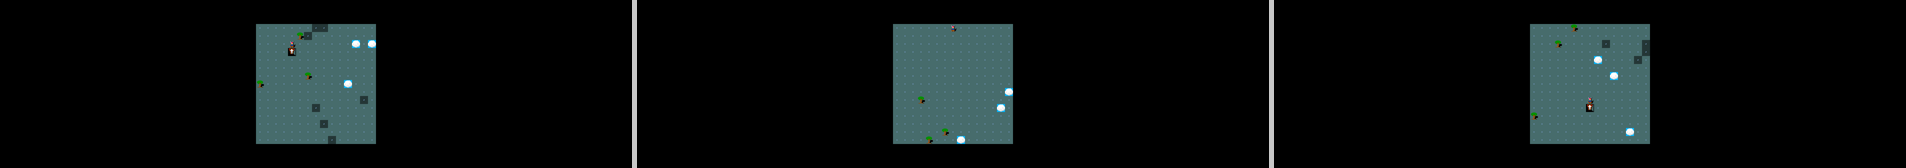

In [19]:
des_file = """
MAZE: "mylevel", ' '
FLAGS:premapped
GEOMETRY:center,center
MAP
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
ENDMAP
REGION: (0,0,20,20), lit, "ordinary"

$left = selection: fillrect (0,0,6,14)
$right = selection: fillrect (8,0,14,14)

TERRAIN: rndcoord($left), 'T'
TERRAIN: rndcoord($left), 'T'
TERRAIN: rndcoord($left), 'T'
TERRAIN: rndcoord($right), 'C'
TERRAIN: rndcoord($right), 'C'
TERRAIN: rndcoord($right), 'C'

"""
render_des_file(des_file.replace("%rect%", rect), n_images=3)

We can also use the `REPLACE_TERRAIN` command, rather than just the `TERRAIN` command. This command takes a region, a terrain to replace, a terrain to replace with, and a probability (specified in a percentage), and then replaces each tile of the terrain to replace in the region with the terrain to replace with with the probability specified. Below, we randomly place some trees in the top left and clouds in the top right (by replacing floor), fill the bottom with lava and then randomly replace some of the laval with ice.

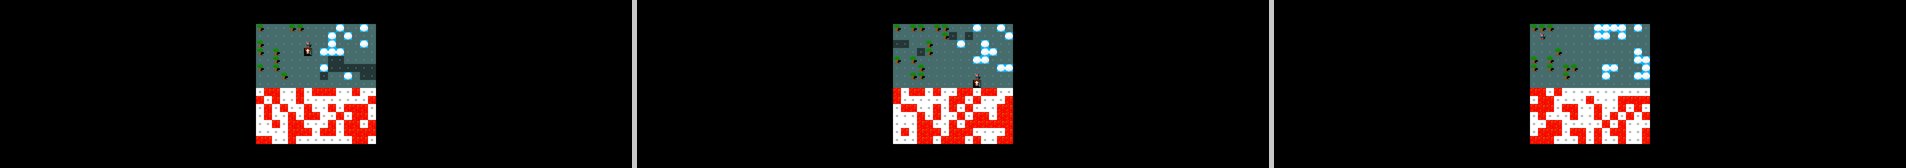

In [20]:
des_file = """
MAZE: "mylevel", ' '
FLAGS:premapped
GEOMETRY:center,center
MAP
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
ENDMAP
REGION: (0,0,20,20), lit, "ordinary"

$top_left_region = (0,0,6,6)
$top_right_region = (8,0,14,6)
$bottom_region = (0,8,14,14)

REPLACE_TERRAIN: $top_left_region, '.', 'T', 20%
REPLACE_TERRAIN: $top_right_region, '.', 'C', 20%

TERRAIN: fillrect $bottom_region, 'L'
REPLACE_TERRAIN: $bottom_region, 'L','I', 50%

"""
render_des_file(des_file, n_images=3)

Another way of generating selections (instead of `rect` or `fillrect`) is using `line` or `randline`. These both take a start and end position, and `randline` also takes a roughness parameter controlling how random the line is between the two coordinates. Here we generate a straight line of trees using `line`, and several different random lines of clouds with different roughnesses using `randline`

Using roughness 0


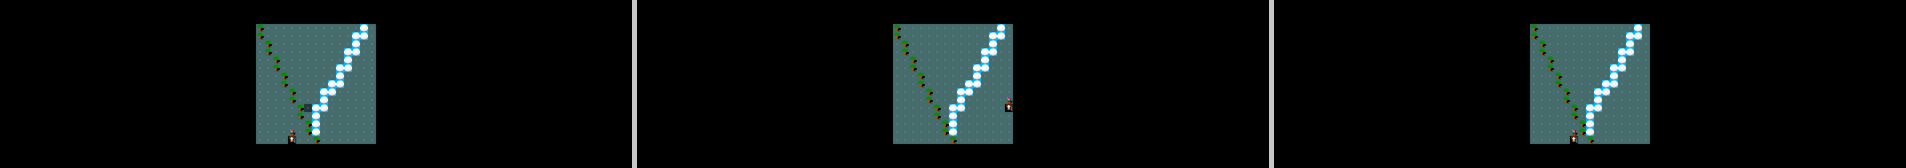

Using roughness 5


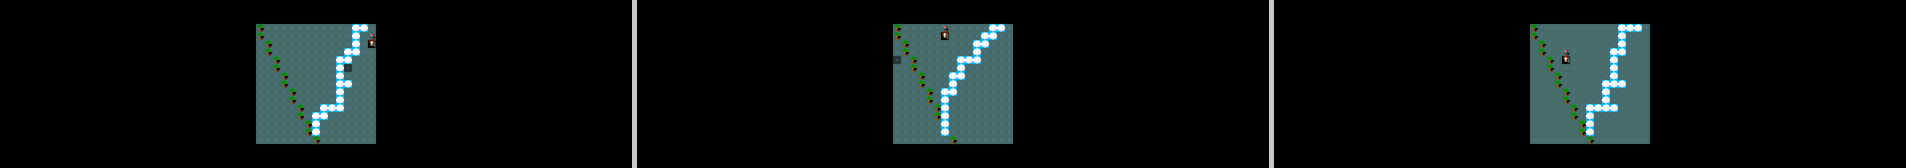

Using roughness 15


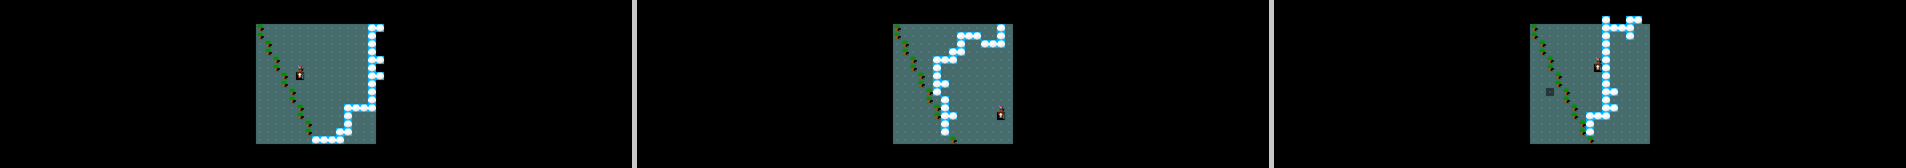

Using roughness 30


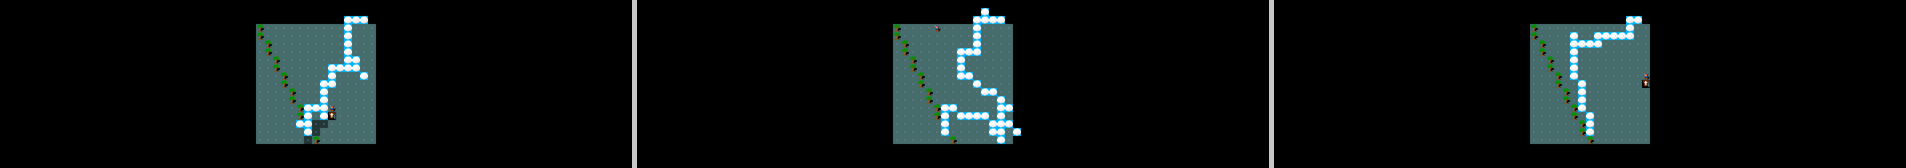

In [21]:
des_file = """
MAZE: "mylevel", ' '
FLAGS:premapped
GEOMETRY:center,center
MAP
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
ENDMAP
REGION: (0,0,20,20), lit, "ordinary"

$top_left = (0,0)
$top_right = (14,0)
$bottom_middle = (7,14)

$tree_line = selection: line $top_left,$bottom_middle
$cloud_line = selection: randline $top_right,$bottom_middle,%roughness%

TERRAIN: $tree_line, 'T'
TERRAIN: $cloud_line, 'C'

"""
for roughness in (0,5,15,30):
    print(f"Using roughness {roughness}")
    render_des_file(des_file.replace("%roughness%", str(roughness)), n_images=3)

More information on different types of selections can be found in the nethack wiki [here](https://nethackwiki.com/wiki/Des-file_format#Terrain_selections)

### Controlling Randomness

As we've seen so far, there are many different ways of controlling randomness in des-files. We'll cover them all in this section:

  * `randline` and `rndcoord` we've already seen. They're ways of creating random selections or coordinates given some input
  * The des-file format supports conditional statements using the `IF[...]` command. Inside the square brackets can either be a percentage (e.g. `IF[50%]`) or a comparison (e.g. `IF[4 < $variable]`)
  * dice-rolls can be used to generate random integers. They take the form `MdN`, which means to roll `M N`-sided die and sum the result (e.g. `2d4`). These can be used in `IF` statements, like `IF[2d4 < 6]`, or any other place an integer is used.
  * Arrays can be created in des-files, supporting lists of any object of the same type. The `SHUFFLE` command can be used to randomise the order of a list after it's been created, and then the list can be accessed by index to get a random element.

Here we use `IF[%50]` conditionals to place either trees or clouds on the left of the map, and dice-rolls to randomly place lava or ice on the right. We use shuffle to randomly pick one monster, and a dice-roll to randomly pick another

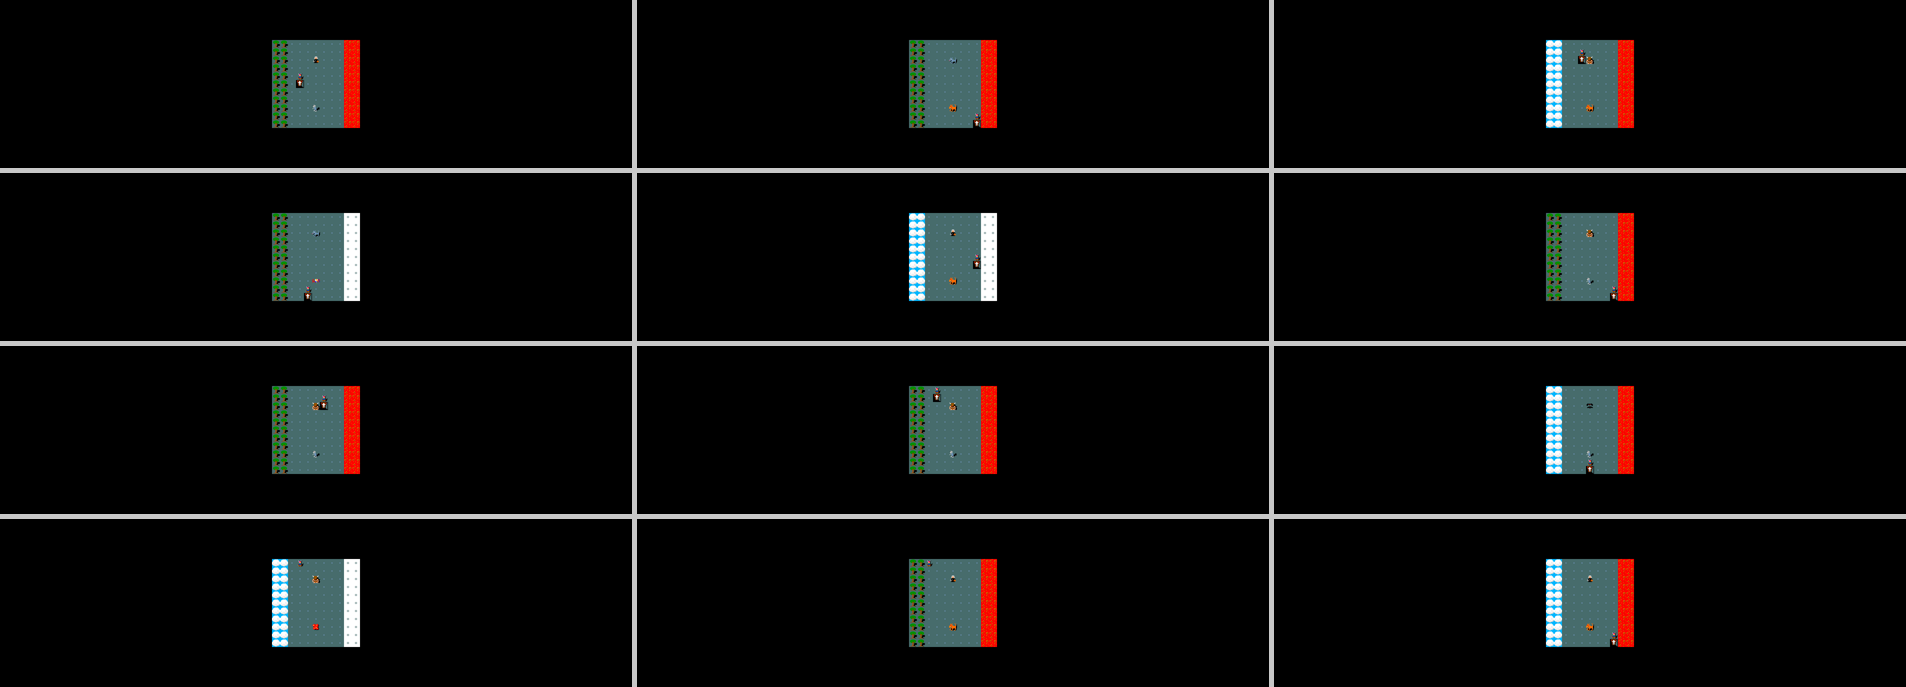

In [22]:
des_file = """
MAZE: "mylevel", ' '
FLAGS:premapped
GEOMETRY:center,center
MAP
...........
...........
...........
...........
...........
...........
...........
...........
...........
...........
...........
ENDMAP
REGION: (0,0,20,20), lit, "ordinary"

$left = selection: fillrect (0,0,1,10)
$right = selection: fillrect (9,0,10,10)

IF [50%] {
    TERRAIN: $left, 'T'
} ELSE {
    TERRAIN: $left, 'C'
}

$roll = 2d6
IF [$roll < 7] {
    TERRAIN: $right, 'I'
} ELSE {
    TERRAIN: $right, 'L'
}

$mon_names = monster: { "Archon", "arch-lich", "vampire lord", "minotaur"}
SHUFFLE: $mon_names
MONSTER: $mon_names[0], (5,2), hostile

$mon_names_new = monster: { "Lich", "grid bug", "hell hound", "red mold"}
$mon_index = 1d4
MONSTER: $mon_names_new[$mon_index], (5,8), hostile
"""
render_des_file(des_file, n_images=12)

# Wrapping up

That brings us to the end of our tutorial. There are more features of NetHack to explore, and we recommend using the NetHack wiki as a useful source of information. Be sure to use MiniHack and the des-file format to create lots of interesting reinforcement learning environments. For more information on MiniHack, see the repository [here](https://github.com/MiniHackPlanet/MiniHack).